# Rent or Buy?

If you have a small pile of money that you are thinking of dropping on the downpayment of a house, should you? This document runs a small stochastic simulation that will help you decide whether it makes sense to buy a house or to rent. 

Conventional wisdom says that you will save money in the long term if you buy a house (the thinking being that you don't "waste" money on rent, and that you "build equity" in the value of the house). However, as this notebook will demonstrate, things are a little more complicated.

The two cases this notebook contrasts are:

* Putting a large lump sum down on the downpaymnet of a house, and then paying monthly payments to pay off the remainder of your debt. Once the house is paid off, those monthly payments will instead be invested in an index fund.
* Putting all the money that you would have put in a downpayment in an index fund, and then spending what you would have spent on monthly mortage payments on rent. 

Perhaps surprisngly, you will find that for many parameters, there is very little difference between the two scenarious, for the following simple reason:

**Yes, the value of your house is going to go up. But the stock market is going to go up a lot faster**. 

This notebook allows you to play with the following parameters interactively:

* **Starting Sum** This is the amount you have saved up. In the "buying" scenario, you put this all in your downpayment. In the "renting" scenario, you put this all in the stock market in an index fund. 
* **Cost of the house** 
* **Tax rate on the house**
* **Interest rate** On your mortage
* **Duration** Of your mortgage 
* **Fraction of monthly payment you are willing to pay as rent** Assuming you are renting
* **Rent hike** Anticipated annual rent increase (percentage)

HTML(value='<h3>Initial savings</h3>')

HTML(value="<p>This amount is the what you have saved up, that you're willing to put down as downpayment for a…

FloatText(value=100000.0, description='Starting $', step=10000.0)

HTML(value='<h3>Buying</h3>')

HTML(value='<h3>Renting and investing</h3>')

<IPython.core.display.Javascript object>


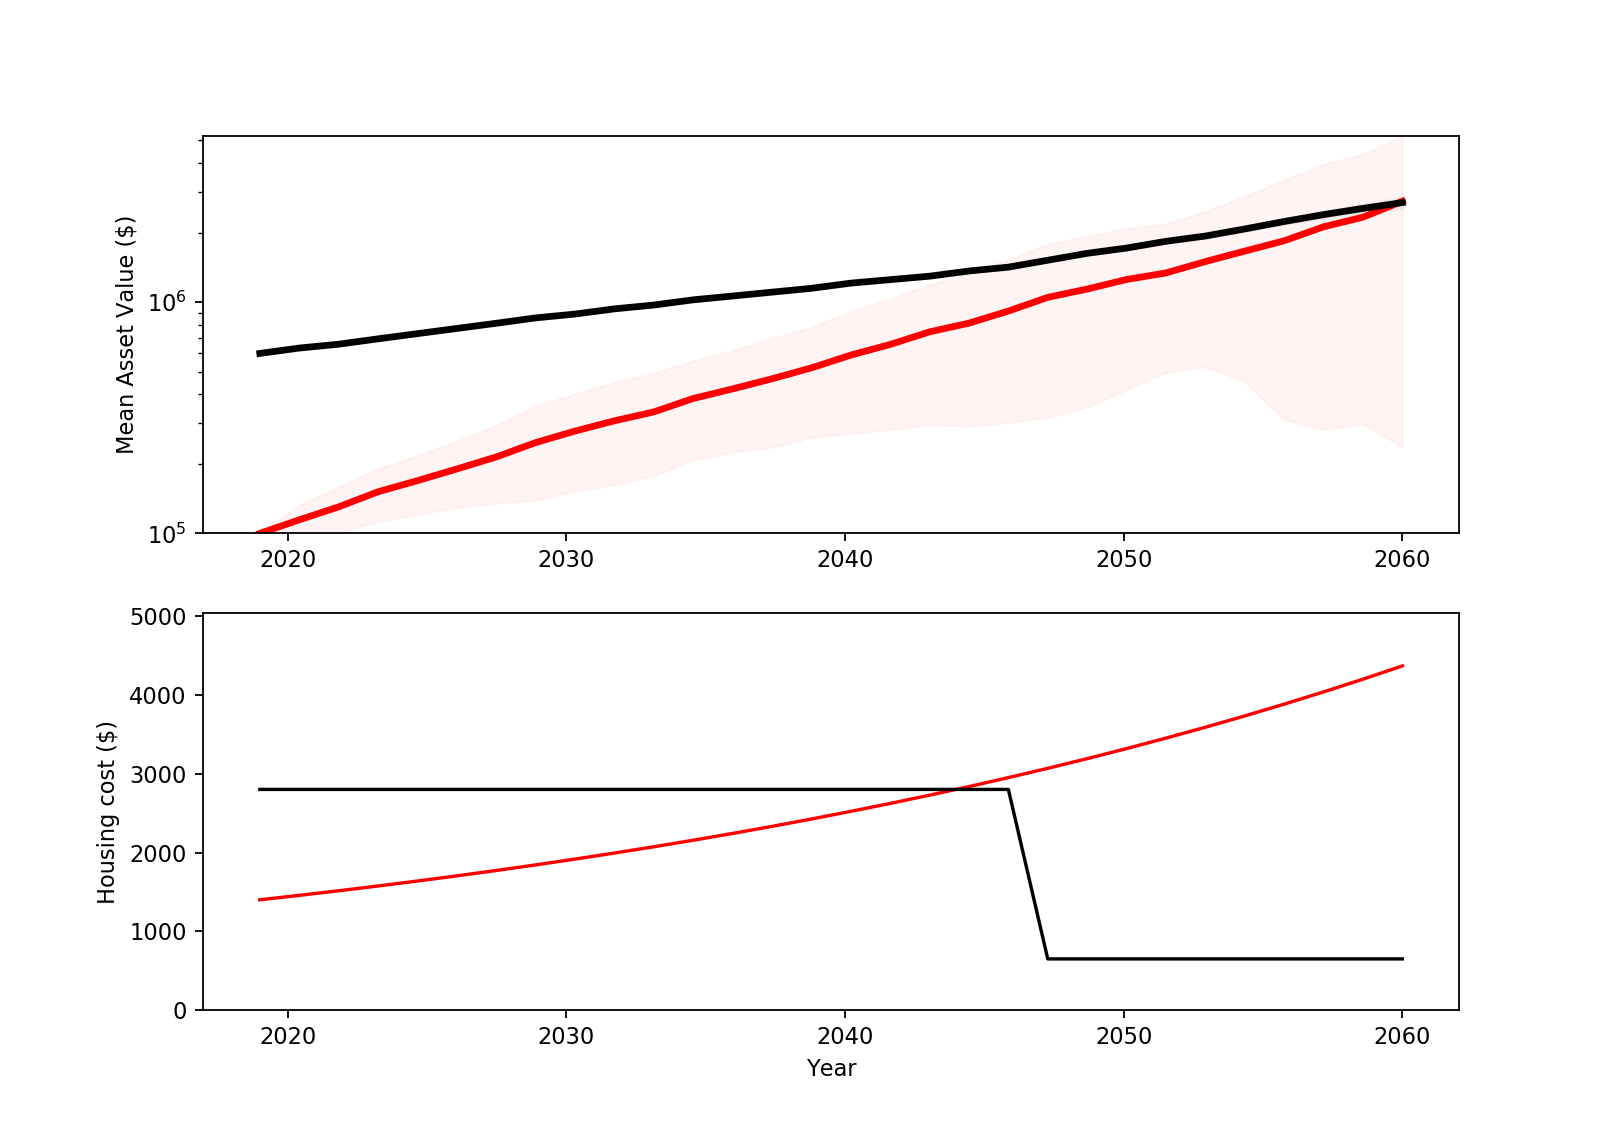

In [4]:

from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib notebook
import math
import random

time = np.linspace(2019, 2060,30)


# annual return of stock market
historical_yearly_return = [18.5,5.2,16.8,31.5,-3.1,
                            30.5,7.6,10.1,1.3,37.6,
                            23.1,33.4,28.6,21.0,-9.1,
                            -11.9,-22.1,28.7,10.9,4.9,
                            15.8,5.5,-37.0,26.5,15.1,2.1,16.0,32.4,13.7,1.4,11.9];


house_appreciation = [5.5, 3.52, 5.3, 3.9]

# income and initial condition parameters
starting_sum = widgets.FloatText(value=100000,min = 0, step = 10000, description = "Starting $")


display(widgets.HTML(value="<h3>Initial savings</h3>"))
display(widgets.HTML(value="<p>This amount is the what you have saved up, that you're willing to put down as downpayment for a house</p>"))
display(starting_sum)



# buying 
house_cost = widgets.IntText(value = 600000, min = 400000, step = 10000, description = "Cost ($)")
tax_rate = widgets.FloatSlider(value = 1, min = 1, step = .1,max=4, description = "Tax (%)")
interest_rate = widgets.FloatSlider(value = 3, min = 1, step = .5, description = "Interest (%)")
duration = widgets.IntSlider(value = 20, min = 5, max=30, step= 1, description = "Duration (y)")

display(widgets.HTML(value="<h3>Buying</h3>"))
box1 = widgets.HBox([house_cost, tax_rate])
box2 = widgets.HBox([interest_rate, duration])
display(widgets.VBox([box1,box2]))





# assuming renting and investing
display(widgets.HTML(value="<h3>Renting and investing</h3>"))


rent_fraction  = widgets.IntSlider(value = 50, min = 0, max = 100, step = 5, description = "Rent frac (%)")
rent_growth  = widgets.IntSlider(value = 1, min = 1, max = 30, step = 1, description = "Rent hike (%)")
rent_box = widgets.HBox([rent_fraction, rent_growth])


display(rent_box)


fig = plt.figure(figsize=(10, 7),num=None)

# first plot shows mean asset value in the two cases. 
ax_value = fig.add_subplot(2, 1, 1)
ax_value.set_ylabel('Mean Asset Value ($)')
rent_asset_mean, = ax_value.plot(time,time*0+1,'r-',linewidth=3)


buy_asset_mean, = ax_value.plot(time,time*0+1,'k-',linewidth=3)


# second plot shows anticipated housing costs for both renting and buying
# this does not include utilies, etc. which are common to both scenarios
ax_costs = fig.add_subplot(2,1,2)
ax_costs.set_xlabel('Year')
ax_costs.set_ylabel('Housing cost ($)')

rent_cost, = ax_costs.plot(time, time*0 + 1, 'r-')
buy_cost, = ax_costs.plot(time, time*0 + 1, 'k-')



fig.canvas.draw()
fig.canvas.draw()
fig.canvas.flush_events()


def income(growth_rate,starting_income):
    predicted_income = 0*time + starting_income
    for i in range(time.size):
        predicted_income[i] = starting_income*math.pow(1 + growth_rate, i)
    return predicted_income
        

    
def estimateStockGrowth(annual_contrib,initial_contrib):
    # how many samples to randomize across? 
    N = 100
    
    ensemble_returns = np.zeros((N,time.size))
    
    # initialize
    ensemble_returns[:,0] = initial_contrib
    
    
    for ti in np.arange(1,time.size):
        for i in np.arange(0,N):
            # pick a random yield rate
            r = random.choice(historical_yearly_return)/100
            ensemble_returns[i,ti] = ensemble_returns[i,ti-1]*(1+r) + annual_contrib[ti]
            
    return ensemble_returns
        

def updateAll(change):
    # compute annual payments assuming buying a house
    r = interest_rate.value/100
    n = duration.value
    annual_payment = (house_cost.value - starting_sum.value)*(r)*math.pow((1+r),n)/(math.pow(1+r,n) - 1)
    temp = 0*time + (tax_rate.value/100)*house_cost.value
    for i in range(0,n):
        temp[i] = annual_payment
        
    # plot monthly housing cost
    buy_cost.set_ydata(temp/12)
    to_invest = temp[0] - temp
    ax_costs.set_ylim([0, annual_payment*.15])
    
    # now compute how much rent we can afford
    temp = 0*time + annual_payment/12*rent_fraction.value/100
    
    for i in range(1,time.size):
        temp[i] = temp[i-1]*(1+rent_growth.value/100)
    
    
    rent_cost.set_ydata(temp)
    
    # so now calculate the amount we expect to be able to invest if we rent
    rent_invest_contrib = annual_payment/12 - temp
    
    ensemble_returns = estimateStockGrowth(rent_invest_contrib,starting_sum.value)
    mean_stock = np.mean(ensemble_returns,axis=0)
    std_stock = np.std(ensemble_returns,axis=0)
    
    
    rent_asset_mean.set_ydata(mean_stock)
    ax_value.collections.clear()
    shade = ax_value.fill_between(time, mean_stock-std_stock, mean_stock + std_stock,color=[1,0.8,0.8],alpha=.2)
    
    ax_value.set_ylim([starting_sum.value, max(mean_stock+std_stock)])
    
    ax_value.set_yscale('log')
    
    
    # now compute house appreciation over time
    house_value = 0*time + house_cost.value
    for i in range(1,time.size):
        r = random.choice(house_appreciation)/100
        house_value[i] = house_value[i-1]*(1+r)
    
    
    # after the house is paid off, annual payments are diverted to investments
    ensemble_returns = estimateStockGrowth(to_invest,0)
    mean_stock = np.mean(ensemble_returns,axis=0) + house_value
    std_stock = np.std(ensemble_returns,axis=0)
    

    buy_asset_mean.set_ydata(mean_stock)

    shade = ax_value.fill_between(time, mean_stock-std_stock, mean_stock + std_stock,color=[.8,0.8,0.8],alpha=.2)
    
        
    fig.canvas.draw()
    fig.canvas.flush_events()
    


    
    
    
# listeners
house_cost.observe(updateAll)
tax_rate.observe(updateAll)
interest_rate.observe(updateAll)
duration.observe(updateAll)
rent_fraction.observe(updateAll)
rent_growth.observe(updateAll)
